# Capstone 1: Inferential Statistics

<a id='TOC'></a>
**Table of Contents**
1. Preliminaries
    1. [Target Hypotheses](#Sec01A)
    2. [Import EMS Incident Data](#Sec01B)
2. Initial vs. Final Severity Level
    1. [](#Sec02A)
    2. [](#Sec02B)
    3. [](#Sec02C)
    4. [](#Sec02D)
    5. [](#Sec02E)
3. Section 3
    1. [](#Sec03A)
    2. [](#Sec03B) 
4. Section 4
    1. [](#Sec04A)
    2. [](#Sec04B)
5. Section 5
    1. [](#Sec05A)
    2. [](#Sec05B)

The goal of this project is to develop machine learning models that predict whether or not the outcome of an EMS incident will result in a fatality. This is a supervised, binary classification problem. Analyses will be performed on a collection of nearly 8 million records of documented incidents, which span the six year period from January 2013 through December 2018, and appropriate predictive models will be developed to achieve the primary objective. This dataset is robust and contains several feature variables, of mixed data types, that describe both various attributes of each incident as well as the responsive action taken by the FDNY. All of the aforementioned factors affect an individual’s survivability once a response is initiated.

Various inferential statistics techniques were performed on the dataset prior to the development of any ML algorithms. One purpose of this process was to examine the correlations between all variables within the dataset in greater depth than preliminary EDA permits. In addition, any feature variable that has a significant impact on the target variable (`fatality`) will also be revealed through these measures.

## 1. PRELIMINARIES

<a id='Sec01A'></a>
#### 1A: Target hypotheses

Null Hypotheses to be Tested:
+ _Are the initial and final severity levels for EMS incidents the same?_ Is there a strong correlation between the incident assessment determined from caller-provided information (`initial_severity_level`) and the assessment made by response personnel on-the-scene (`final_severity_level`)?
+ _Are survival rates for life-threatening and non-life-threatening severity levels the same?_ Is there a significant difference between the survival rates for incidents that are assigned a _life threatening_ severity level (Code 1, 2, and 3) and those that are deemed non-life threatening (Code 4, 5, 6, 7, and 8)?
+ _Are the response times for fatalities and survivals the same?_ Is there a significant difference between the response times of incidents that result in fatalities and those where patients survive?
+ _Are fatality rates highest during summer months?_ Is there a significant difference between the fatality rates for incidents that occur during the summer months (June, July, August) and those that occur during the rest of the year?

[TOC](#TOC)

<a id='Sec01B'></a>
#### 1B: Import EMS incident data

In [2]:
# Import packages and modules
import pandas as pd
import numpy as np

from scipy import stats
# from statsmodels.stats.weightstats import ztest, ttest_ind

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid', palette='pastel', color_codes=True)

from itertools import combinations

import pandas_profiling

In [3]:
# Assign file path
file_path = '../data/clean_EMS_data.csv'

# Read CSV data into a Pandas DataFrame
datetime_cols = ['incident_datetime',
                 'first_assignment_datetime',
                 'first_activation_datetime',
                 'first_on_scene_datetime',
                 'first_to_hosp_datetime',
                 'first_hosp_arrival_datetime',
                 'incident_close_datetime']

df = pd.read_csv(file_path,compression='gzip',
                 parse_dates=datetime_cols,
                 index_col=['incident_datetime'])

In [4]:
df.info(verbose=True,memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7988028 entries, 2013-01-01 00:00:04 to 2018-12-19 00:19:39
Data columns (total 28 columns):
year                           int64
month                          int64
hour                           int64
weekday                        object
borough                        object
zipcode                        float64
latitude                       float64
longitude                      float64
aland_sqmi                     float64
awater_sqmi                    float64
initial_call_type              object
initial_severity_level         int64
final_call_type                object
final_severity_level           int64
held_indicator                 object
first_assignment_datetime      datetime64[ns]
incident_dispatch_area         object
dispatch_time                  int64
first_activation_datetime      datetime64[ns]
first_on_scene_datetime        datetime64[ns]
travel_time                    float64
response_time                  f

In [5]:
# Change dtypes
df['weekday'] = df.borough.astype('category')
df['borough'] = df.borough.astype('category')
df['zipcode'] = df.zipcode.astype('category')
df['held_indicator'] = df.held_indicator.astype('category')
df['incident_dispatch_area'] = df.incident_dispatch_area.astype('category')
df['incident_disposition_code'] = df.incident_disposition_code.astype('category')

In [6]:
df.info(verbose=True,memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7988028 entries, 2013-01-01 00:00:04 to 2018-12-19 00:19:39
Data columns (total 28 columns):
year                           int64
month                          int64
hour                           int64
weekday                        category
borough                        category
zipcode                        category
latitude                       float64
longitude                      float64
aland_sqmi                     float64
awater_sqmi                    float64
initial_call_type              object
initial_severity_level         int64
final_call_type                object
final_severity_level           int64
held_indicator                 category
first_assignment_datetime      datetime64[ns]
incident_dispatch_area         category
dispatch_time                  int64
first_activation_datetime      datetime64[ns]
first_on_scene_datetime        datetime64[ns]
travel_time                    float64
response_time          

[TOC](#TOC)

*** 

## 2. INITIAL VS FINAL SEVERITY LEVEL

<a id='Sec02A'></a>
#### 2A: Calculate correlation coefficent between initial and final severity levels

To what extent does the incident assessment determined from caller-provided information (initial_severity_level_code) correlate with the assessment made by response personnel on-the-scene (final_severity_level_code)?

In [23]:
# Subset all incidents by initial and final severity levels
severity_levels = df[['initial_severity_level','final_severity_level','fatality']]
severity_levels.head()

,initial_severity_level,final_severity_level,fatality
incident_datetime,,,
2013-01-01 00:00:04,4,4,False
2013-01-01 00:05:52,7,7,False
2013-01-01 00:20:37,6,6,False
2013-01-01 01:53:11,4,4,False
2013-01-01 01:54:28,4,4,False


In [24]:
# Determine correlation between 'initial_severity_level' and 'final_severity_level'
x=np.array(severity_levels['initial_severity_level'])
y=np.array(severity_levels['final_severity_level'])

np.corrcoef(x,y)

array([[1.        , 0.93524575],
       [0.93524575, 1.        ]])

There is a strong, linear correlation between the initial_severity_level and the final_severity_level. This indicates that the determination for the severity of an incident made by dispatch--based on the information obtained by a caller--aligns closely to the determination made by on-scene EMS crew.

For this reason, the initial_severity_level will be omitted from any analyses used to develop ML algorithms given that it is a redundant predictor variable.

<Figure size 1080x1080 with 0 Axes>

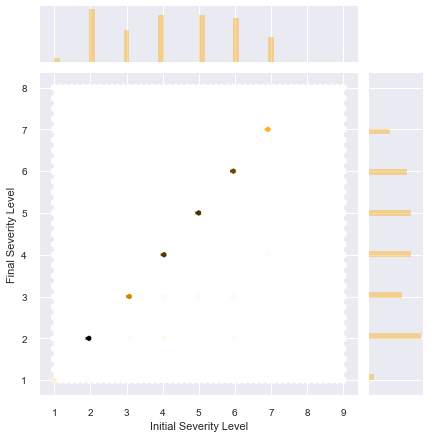

In [33]:
# Visualize spread of data
plt.figure(figsize=(15,15))
ax2A = sns.jointplot(x,y,kind='hex',color='#FFA500')
#ax2A.set_size_inches(5,5)
ax2A.set_axis_labels('Initial Severity Level', 'Final Severity Level')

In [16]:
response_times = np.array(df['response_time'][df.response_time<1400])

In [17]:
# Calculate statistics
median = np.median(response_times)
mean = np.mean(response_times)
std = np.std(response_times)

# Print results
print('Median:    {:.4f}'.format(median))
print('Mean:      {0:.4f}\nStd. Dev.: {1:.4f}'.format(mean,std))

Median:    426.0000
Mean:      477.6980
Std. Dev.: 244.8923


#### Part B: Examine a histogram of the distribution

Based on prior exploratory data analysis, the maximum total response  time--excluding outliers--is ##. Therefore, the PDF will be examined for all response times less than this value.

Text(0.5, 1.0, 'Distribution of Response Times')

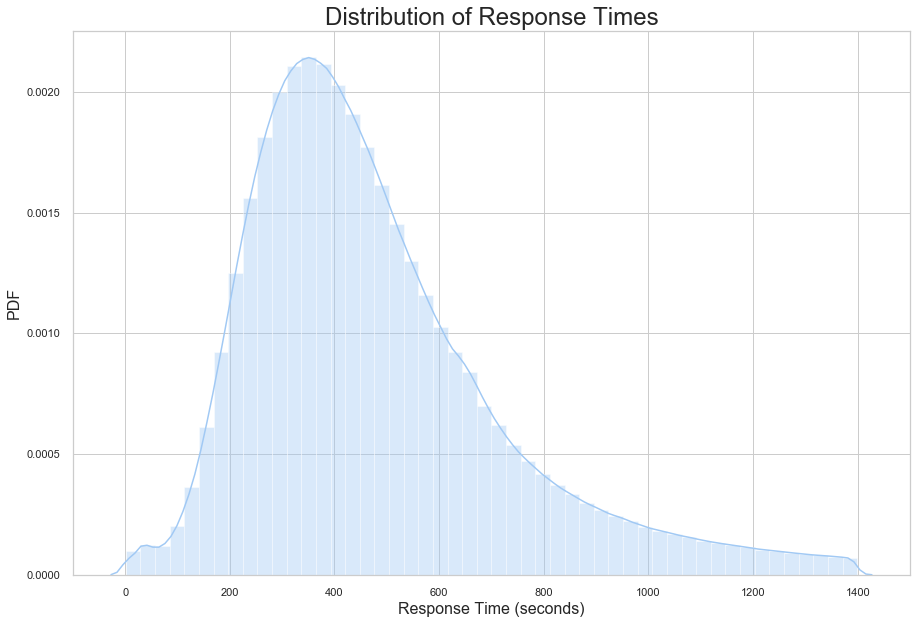

In [18]:
# Inspect PDF for distribution of total response times
fig1A,ax1A = plt.subplots(figsize=(15,10))

ax1A = sns.distplot(df['response_time'][df.response_time<1400])
ax1A.set_xlabel('Response Time (seconds)',size=16)
ax1A.set_ylabel('PDF',size=16)
ax1A.set_title('Distribution of Response Times',size=24)

#### Part C: Perform a Goodness-of-Fit test

In [ ]:
"""
    PERFORM SEVERAL DISTRIBUTION TEST IN ORDER TO IDENTIFY THE 
    BEST FIT FOR THE DATASET. USE THE FOLLOWING MEASURES:
    * Anderson-Darling statistic (AD)
    * P-value
    * LRT P
"""

In [1]:
# Perform KS Test on response times
stats.kstest(response_times,'gamma',())

#### Part C: Fit a theoretical __ distribution to the actual distribution of response times

In [26]:
# Calculate mean and standard deviation of the response times
mean = np.mean(df['total_response_time'])
std = np.std(df['total_response_time'])

# Print results
print('Mean of Response Time:  {:.4f} \nStDev of Response Time: {:.4f}'.format(mean,std))

Mean of Response Time:  561.0861 
StDev of Response Time: 547.4898


In [ ]:
# Create a sample of n = 1000000 [distribution type] distributed random temperatures
sample = np.random.normal(mean, std, 1000000)

# Define empirical cumulative distribution function (ecdf)
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [ ]:
# Compute the ecdf for the temperature data and the sample
x,y = ecdf(df['total_response_time'])
x_theor,y_theor = ecdf(sample)

# Plot and show the actual and theoretical distribution of temperatures
fig1B,ax1B = plt.subplots(figsize=(15,10))
_ = plt.plot(x_theor,y_theor)
_ = plt.plot(x,y,marker='.',linestyle='none')
_ = plt.xlabel('Response Time (seconds)')
_ = plt.ylabel('CDF')
_ = plt.title('Theoretical vs Actual Distribution of Response Times')
_ = plt.legend(['Theoretical CDF','Sample CDF'])
plt.show()

### Pandas Profiling Report

In [ ]:
df.profile_report(style={'full_width':True})

In [14]:
#df.describe()

### Incident Outcomes

In [6]:
# Subset all incidents based on outcome
fatalities = df[df.fatality==True]
survivals = df[df.fatality==False]

In [7]:
n_fat = len(fatalities) # number of fatalities
n_sur = len(survivals) # number of survivals
print('Number of Fatalities: {}\nNumber of Survivals:  {}'.format(n_fat,n_sur))

Number of Fatalities: 338684
Number of Survivals:  7649344


### Analysis: Total Response Times ($t_R$)

Assuming a 95% confidence interval, the null hypothesis will only be rejected if the resulting test statistic is more than 1.96 standard deviations away from the mean.

$\mu_R,_F$ = Avg. dispatch time for incidents resulting in fatalities

$\mu_R,_S$ = Avg. dispatch time for incidents resulting in survival



#### Hypothesis Test

$H_0$: $\mu_R,_F$ = $\mu_R,_S$ (the mean dispatch times are the same)

$H_A$: $\mu_R,_F$ $\neq$ $\mu_R,_S$ (the mean dispatch times are different)

Text(0.5, 1.0, 'Distribution of Response Times (Survivals)')

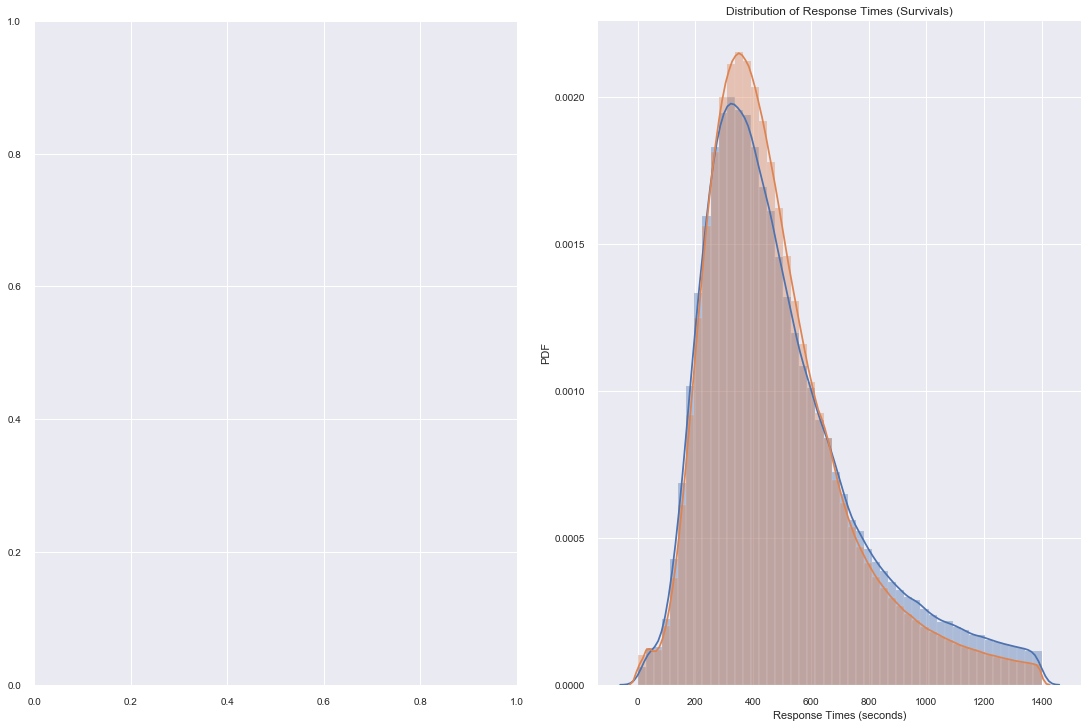

In [10]:
# Inspect PDF for distribution of dispatch times 
fig1,(ax1A,ax1B) = plt.subplots(1,2,figsize=(15,10),constrained_layout=True)

ax1A = sns.distplot(fatalities['total_response_time'][fatalities['total_response_time']<1400])
ax1A.set_xlabel('Response Times (seconds)')
ax1A.set_ylabel('PDF')
ax1A.set_title('Distribution of Response Times (Fatalities)')

ax1B = sns.distplot(survivals['total_response_time'][survivals['total_response_time']<1400])
ax1B.set_xlabel('Response Times (seconds)')
ax1B.set_ylabel('PDF')
ax1B.set_title('Distribution of Response Times (Survivals)')

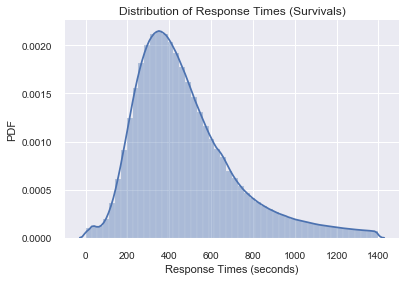

In [13]:
# Inspect PDF for distribution of dispatch times 
sns.distplot(survivals['total_response_time'][survivals['total_response_time']<1400])
_ = plt.xlabel('Response Times (seconds)')
_ = plt.ylabel('PDF')
_ = plt.title('Distribution of Response Times (Survivals)')

In [54]:
# Calculate avg. response times for fatalities and survivals
mu_resp_f = np.mean(fatalities['total_response_time'])
mu_resp_s = np.mean(survivals['total_response_time'])

print('Avg. Response Time for Fatalities: {}\nAvg. Response Time for Survivals: {}'.format(mu_resp_f,mu_resp_s))
# 
#t_stat, t_pval = stats.ttest_ind(mu_resp_f,mu_resp_s,equal_var=False)
#print('z-statistic: {:4f}\np-value: {}'.format(abs(t_stat),t_pval))

Avg. Dispatch Time or Fatalities: 196.69020936648843
Avg. Dispatch Times for Survivals: 79.09842896162398


In [12]:
#survivals.head()

### Analysis: Response Times ($t_r$)

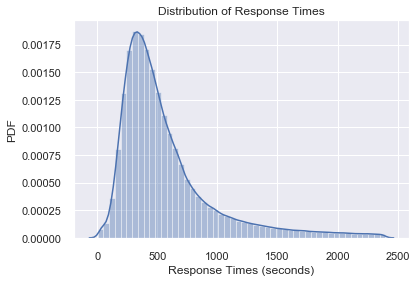

In [48]:
# Inspect PDF for distribution of response times 
sns.distplot(fatalities['incident_response_seconds_qy'][fatalities['incident_response_seconds_qy']<2400])
_ = plt.xlabel('Response Times (seconds)')
_ = plt.ylabel('PDF')
_ = plt.title('Distribution of Response Times')

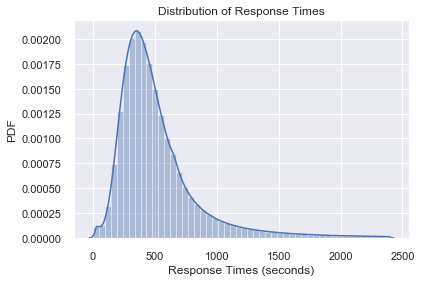

In [49]:
# Inspect PDF for distribution of response times 
sns.distplot(survivals['incident_response_seconds_qy'][survivals['incident_response_seconds_qy']<2400])
_ = plt.xlabel('Response Times (seconds)')
_ = plt.ylabel('PDF')
_ = plt.title('Distribution of Response Times')

### Feature Selection

In [8]:
arr = df.values
X = arr[:,0:21]
y = arr[:,21]

In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
# Feature extraction
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, y)

# Summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)

features = fit.transform(X)
# Summarize selected features
print(features[0:5,:])

In [8]:
df.fatality.value_counts()

False    7808348
True      348606
Name: fatality, dtype: int64

In [5]:
cols = ['final_call_type','final_severity_level_code','incident_datetime',
        'first_assignment_datetime','valid_dispatch_rspns_time_indc',
        'dispatch_response_seconds_qy','valid_incident_rspns_time_indc',
        'incident_response_seconds_qy','incident_travel_tm_seconds_qy']

In [78]:
#duration_err = df[np.array(df.dispatch_response_seconds_qy)+np.array(df.incident_travel_tm_seconds_qy)!=np.array(df.incident_response_seconds_qy)]
#duration_err.shape

In [9]:
# Create samples for fatalities and survivals
fatalities = df[df.fatality==True]
survivals = df[df.fatality==False]

### Analysis of Dispatch Response Times

In [35]:
fatalities.head()

,incident_datetime,borough,zipcode,incident_dispatch_area,held_indicator,initial_call_type,initial_severity_level_code,final_call_type,final_severity_level_code,first_assignment_datetime,...,first_activation_datetime,first_on_scene_datetime,valid_incident_rspns_time_indc,incident_response_seconds_qy,incident_travel_tm_seconds_qy,first_to_hosp_datetime,first_hosp_arrival_datetime,incident_close_datetime,incident_disposition_code,fatality
2,2013-01-01 00:01:04,QUEENS,11418.0,Q3,N,ARREST,1,ARREST,1,2013-01-01 00:01:33,...,2013-01-01 00:01:58,2013-01-01 00:08:13,Y,429.0,400.0,NaT,NaT,2013-01-01 00:38:05,83.0,True
35,2013-01-01 00:10:18,MANHATTAN,10017.0,M3,Y,DRUG,4,DRUG,4,2013-01-01 00:19:10,...,2013-01-01 00:19:34,2013-01-01 00:29:04,Y,1126.0,594.0,NaT,NaT,2013-01-01 00:43:50,96.0,True
36,2013-01-01 00:10:27,MANHATTAN,10013.0,M1,Y,INJURY,5,INJURY,5,2013-01-01 00:17:28,...,2013-01-01 00:17:36,2013-01-01 00:27:31,Y,1024.0,603.0,NaT,NaT,2013-01-01 00:35:19,96.0,True
53,2013-01-01 00:17:02,BRONX,10453.0,B2,N,JUMPDN,2,JUMPDN,2,2013-01-01 00:17:27,...,2013-01-01 00:17:43,2013-01-01 00:21:54,Y,292.0,267.0,NaT,NaT,2013-01-01 01:13:30,83.0,True
59,2013-01-01 00:18:15,MANHATTAN,10020.0,M3,Y,DRUG,4,DRUG,4,2013-01-01 01:12:31,...,2013-01-01 01:12:43,2013-01-01 01:30:24,Y,4329.0,1073.0,NaT,NaT,2013-01-01 01:47:17,96.0,True


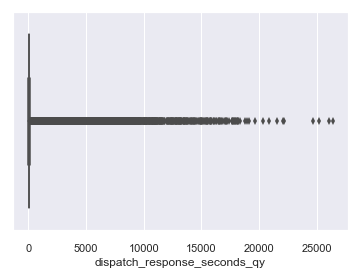

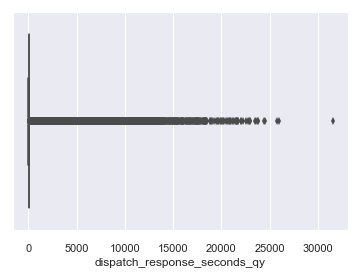

In [37]:
# Create metrics for dispatch times per sample
f_disp = fatalities.dispatch_response_seconds_qy # dispatch time for fatalities
s_disp = survivals.dispatch_response_seconds_qy # dispatch time for survivals

# Calculate mean duration per sample
mu_f_disp = np.mean(f_disp)
mu_s_disp = np.mean(s_disp)

# Calculate standard errors (se) for each duration per sample
se_f_disp = stats.sem(f_disp)
se_s_disp = stats.sem(s_disp)

# Calculate margin of error (me) at 95% CI for each duration per sample
me_f_disp = 1.96*se_f_disp
me_s_disp = 1.96*se_f_disp


ax1 = sns.boxplot(f_disp)

plt.show()

ax2 = sns.boxplot(s_disp)
plt.show()

In [18]:
# Create metrics for durations per sample
f_trav = fatalities.incident_travel_tm_seconds_qy # travel time for fatalities
f_resp = fatalities.incident_response_seconds_qy # response time for fatalities
s_trav = survivals.incident_travel_tm_seconds_qy # travel time for survivals
s_resp = survivals.incident_response_seconds_qy # response time for survivals

# Calculate mean for duration per sample
mu_f_trav = np.mean(f_trav)
mu_f_resp = np.mean(f_resp)
mu_s_trav = np.mean(s_trav)
mu_s_resp = np.mean(s_resp)

# Calculate standard errors (se) for each duration per sample
se_f_trav = stats.sem(f_trav)
se_f_resp = stats.sem(f_resp)
se_s_trav = stats.sem(s_trav)
se_s_resp = stats.sem(s_resp)

# Calculate margin of error (me) at 95% CI for each duration per sample
me_f_trav = 1.96*se_f_disp
me_f_resp = 1.96*se_f_disp
me_s_trav = 1.96*se_f_disp
me_s_resp = 1.96*se_f_disp

In [28]:
f_disp.value_counts()

13       11249
14       10935
12       10918
15       10646
11       10432
16       10389
17       10055
10        9628
18        9621
19        9171
20        8662
21        8162
9         8115
22        7597
23        7296
24        6802
25        6536
8         6447
26        6036
27        5730
28        5317
29        5243
7         4976
30        4765
31        4557
32        4302
33        3994
34        3778
35        3684
6         3683
         ...  
10943        1
8409         1
7742         1
3960         1
7097         1
5499         1
7998         1
5951         1
13439        1
10456        1
8159         1
7290         1
7903         1
12856        1
3771         1
3805         1
13244        1
4924         1
9085         1
3549         1
4987         1
5304         1
4731         1
5436         1
9432         1
8317         1
22068        1
17974        1
5692         1
4769         1
Name: dispatch_response_seconds_qy, Length: 6141, dtype: int64

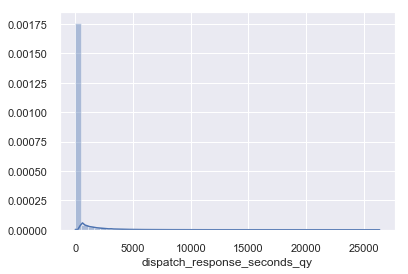

In [20]:
# Distribution of Dispatch Response Times
sns.distplot(f_disp)

### Preliminary Fatality Statistics

In [15]:
fatalities = df[df.fatality==True] # subset of incidents that result in death

n_fatalities = fatalities.fatality.count() # total number of fatalities

f_resp = fatalities.incident_response_seconds_qy # response time for fatalities
f_trav = fatalities.incident_travel_tm_seconds_qy # travel time for fatalities

# Response time statistics for fatalities
mu_f_resp = np.mean(f_resp)
sig_f_resp = np.std(f_resp)


# Output results
print('Fatality Statistics'.upper())
print('Total Fatalities (2013-2018): {}'.format(n_fatalities))
print("Mean Response Time (seconds): {:.3f}\nStDev of Response Time (seconds): {:.3f}"\
      .format(mu_f_resp,sig_f_resp))

AttributeError: 'DataFrame' object has no attribute 'incident_response_seconds_qy'

In [76]:
#fatalities.head()
fatalities[cols].head()

,final_call_type,final_severity_level_code,first_assignment_datetime,valid_dispatch_rspns_time_indc,dispatch_response_seconds_qy,valid_incident_rspns_time_indc,incident_response_seconds_qy,incident_travel_tm_seconds_qy
2,ARREST,1,2013-01-01 00:01:33,Y,29,Y,429.0,400.0
35,DRUG,4,2013-01-01 00:19:10,Y,532,Y,1126.0,594.0
36,INJURY,5,2013-01-01 00:17:28,Y,421,Y,1024.0,603.0
53,JUMPDN,2,2013-01-01 00:17:27,Y,25,Y,292.0,267.0
59,DRUG,4,2013-01-01 01:12:31,Y,3256,Y,4329.0,1073.0


### Preliminary Survival Statistics

In [42]:
survivals = df[df.fatality==False] # subset of incidents that result in survival

n_survivals = survivals.fatality.count() # number of survivals

s_resp = survivals.incident_response_seconds_qy # response time for survivals
s_trav = survivals.incident_travel_tm_seconds_qy # travel time for survivals

# Response time statistics for survivals
mu_s_resp = np.mean(s_resp)
sig_s_resp = np.std(s_resp)

# Travel time statistics for survivals
mu_s_trav = np.mean(s_trav)
sig_s_trav = np.std(s_trav)

# Output results
print('Survival Statistics'.upper())
print('Number of Survivals: {}'.format(n_survivals))
print("Mean Response Time (seconds): {:.3f}\nStDev of Response Time (seconds): {:.3f}"\
      .format(mu_s_resp,sig_s_resp))
print("Mean Travel Time (seconds): {:.3f}\nStDev of Travel Time (seconds): {:.3f}"\
      .format(mu_s_trav,sig_s_trav))

SURVIVAL STATISTICS
Number of Survivals: 7878863
Mean Response Time (seconds): 548.530
StDev of Response Time (seconds): 515.115
Mean Travel Time (seconds): 470.160
StDev of Travel Time (seconds): 343.392


In [ ]:
pandas_profiling.ProfileReport(df)

### Separate Feature and Target Variables

In [5]:
# Numeric Variables
num_vars = []

# Categorical Variables
cat_vars = df[['borough',
            'zipcode',
            'incident_dispatch_area',
            'initial_severity_level_code',
            'final_severity_level_code',
            'initial_call_type',
            'final_call_type',
            'held_indicator']]

In [1]:
y_var = np.array(df['fatality'])

NameError: name 'np' is not defined

In [19]:
X_vars = []

In [8]:
# Create df for each categorical variable
borough = df.borough
zipcode = df.zipcode
dispatch_area = df.incident_dispatch_area
initial_severity = df.initial_severity_level_code
final_severity = df.final_severity_level_code
initial_call_type = df.initial_call_type
final_call_type = df.final_call_type
held = df.held_indicator

### Spearman's Rank Correlation

Identify the correlation between each possible pair of feature variables.

In [ ]:
#spear_coef, p_val = stats.spearmanr(borough,zipcode)

/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


ValueError: max must be larger than min in range parameter.

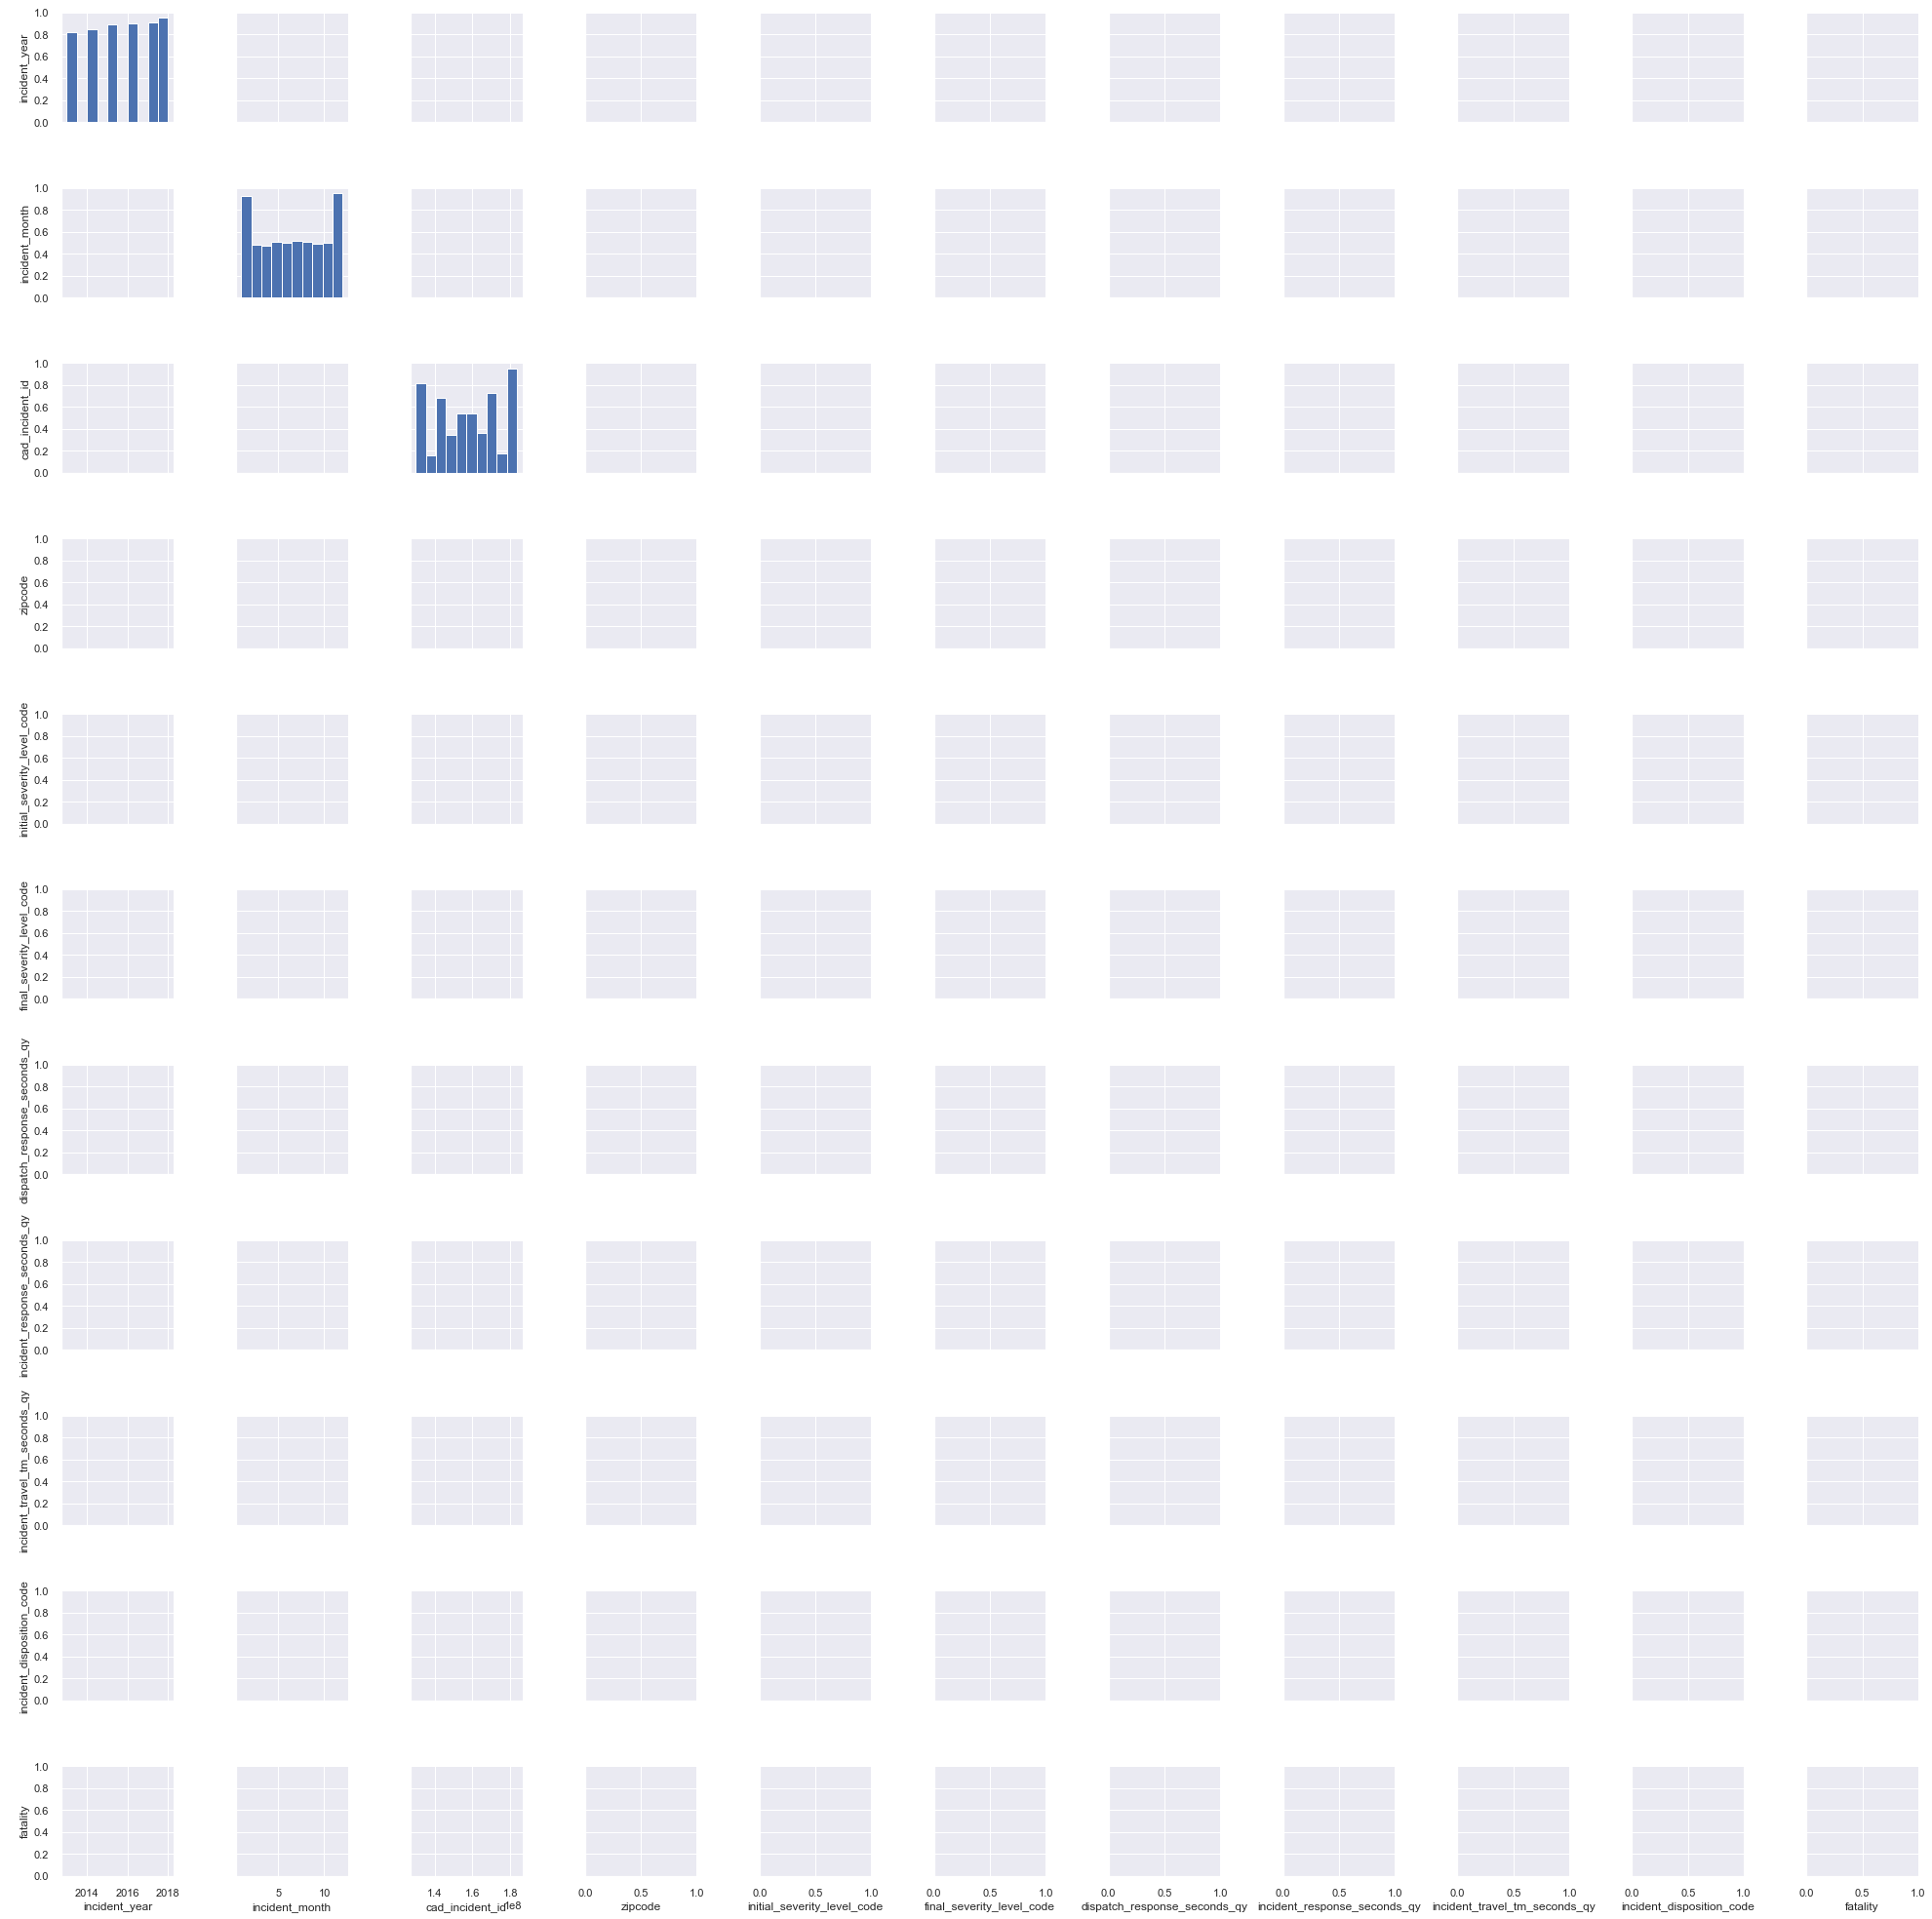

In [8]:
#sns.pairplot(df)

### Chi-Square Analysis

### Simple Statistics

In [30]:
df.total_response_time.max()/60

532.1833333333333

In [27]:
df.total_response_time.min()

0.0

ECDF

In [5]:
# Define ECDF function
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [22]:
x1,y1 = ecdf(np.array(df.incident_response_seconds_qy))

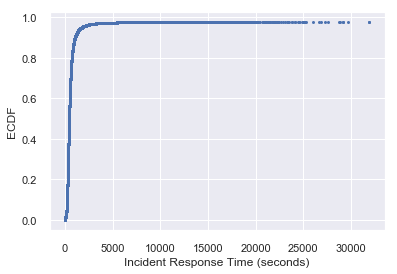

In [23]:
# Generate plot
_ = plt.plot(x1,y1,marker='.',linestyle='none')


# Label the axes
_ = plt.xlabel('Incident Response Time (seconds)')
_ = plt.ylabel('ECDF')

# Display the plot
plt.show()

In [24]:
x2,y2 = ecdf(np.array(df.incident_response_seconds_qy)/60)

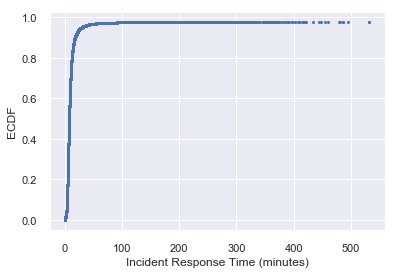

In [25]:
# Generate plot
_ = plt.plot(x2,y2,marker='.',linestyle='none')


# Label the axes
_ = plt.xlabel('Incident Response Time (minutes)')
_ = plt.ylabel('ECDF')

# Display the plot
plt.show()

In [40]:
df.incident_response_seconds_qy.isnull().count()

8431649

In [38]:
df.incident_response_seconds_qy.value_counts().unique()

array([71167, 16974, 16936, ...,     3,     2,     1])

In [32]:
mean_response_time = np.mean(df.incident_response_seconds_qy)
mean_response_time

556.7533044867662

In [33]:
print('Median Response Time (sec): {}'.format(np.median(df.incident_response_seconds_qy)))

Median Response Time (sec): nan


/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [9]:
df.head()

incident_datetime borough  \
incident_year incident_month cad_incident_id                               
2013          1              130010001       2013-01-01 00:00:04   BRONX   
                             130010002       2013-01-01 00:00:19   BRONX   
                             130010004       2013-01-01 00:01:04  QUEENS   
                             130010005       2013-01-01 00:01:16   BRONX   
                             130010006       2013-01-01 00:01:26   BRONX   

                                              zipcode incident_dispatch_area  \
incident_year incident_month cad_incident_id                                   
2013          1              130010001        10472.0                     B3   
                             130010002        10454.0                     B1   
                             130010004        11418.0                     Q3   
                             130010005        10453.0                     B2   
                             130010006        10457.0                     B2   

                                             held_indicator initial_call_type  \
incident_year incident_month cad_incident_id                                    
2013          1              130010001                    N            RESPIR   
                             130010002                    N              CARD   
                             130010004                    N            ARREST   
                             130010005                    N              SICK   
                             130010006                    N            INJURY   

                                              initial_severity_level_code  \
incident_year incident_month cad_incident_id                                
2013          1              130010001                                  4   
                             130010002                                  3   
                             130010004                                  1   
                             130010005                                  6   
                             130010006                                  5   

                                             final_call_type  \
incident_year incident_month cad_incident_id                   
2013          1              130010001                RESPIR   
                             130010002                  CARD   
                             130010004                ARREST   
                             130010005                  SICK   
                             130010006                INJURY   

                                              final_severity_level_code  \
incident_year incident_month cad_incident_id                              
2013          1              130010001                                4   
                             130010002                                3   
                             130010004                                1   
                             130010005                                6   
                             130010006                                5   

                                             first_assignment_datetime  \
incident_year incident_month cad_incident_id                             
2013          1              130010001             2013-01-01 00:01:45   
                             130010002             2013-01-01 00:01:18   
                             130010004             2013-01-01 00:01:33   
                             130010005             2013-01-01 00:02:12   
                             130010006             2013-01-01 00:01:58   

                                               ...     \
incident_year incident_month cad_incident_id   ...      
2013          1              130010001         ...      
                             130010002         ...      
                             130010004         ...      
                             130010005         ...      
         

### Something

In [ ]:
pandas_profiling.ProfileReport(df)